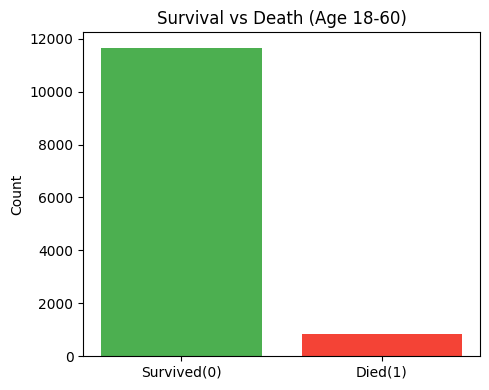

survived: 11656 (93.18%)
dead: 853 (6.82%)


In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# =========================
# 설정
# =========================
src_dir = "../data/out_by_subject_csv/"
label_col = "died_in_icu"
age_col = "feature1"  # 나이 컬럼
exclude_cols = {label_col, "observation", "patientunitstayid", age_col}


# =========================
# 1) 나이 18~60 필터 + 라벨/결측 계산
# =========================
paths = glob.glob(os.path.join(src_dir, "*.csv"))

rows = []
for path in paths:
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()

    if label_col not in df.columns or age_col not in df.columns:
        continue

    # 나이 필터 (해당 파일 내 한 번이라도 18~60이면 포함)
    age = pd.to_numeric(df[age_col], errors="coerce")
    if not ((age >= 18) & (age <= 60)).any():
        continue

    feature_cols = [c for c in df.columns if c not in exclude_cols]

    miss = df[feature_cols].isna().sum().sum()
    total = df[feature_cols].size
    miss_rate = miss / total if total > 0 else 0

    label = int((df[label_col].astype(str).str.strip() == "1").any())
    patient_id = os.path.splitext(os.path.basename(path))[0]

    rows.append([patient_id, miss, total, miss_rate, label, path])

df_stats = pd.DataFrame(
    rows,
    columns=["patient_id", "missing_count", "total_cells", "missing_rate", "label", "path"]
)

# =========================
# 2) 사망/생존 비율 시각화
# =========================
surv_count = (df_stats["label"] == 0).sum()
dead_count = (df_stats["label"] == 1).sum()

plt.figure(figsize=(5, 4))
plt.bar(["Survived(0)", "Died(1)"], [surv_count, dead_count], color=["#4CAF50", "#F44336"])
plt.title("Survival vs Death (Age 18-60)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

total = surv_count + dead_count

if total == 0:
    print("no data after age filter")
else:
    surv_ratio = surv_count / total * 100
    dead_ratio = dead_count / total * 100
    print(f"survived: {surv_count} ({surv_ratio:.2f}%)")
    print(f"dead: {dead_count} ({dead_ratio:.2f}%)")



In [7]:
# =========================
# 3) 92:8 비율 맞춰 train/test 분할 + 병합
# =========================

ratio_surv = 0.93
test_size = 0.07
random_state = 42

df_stats = df_stats.sort_values(["missing_rate", "missing_count"]).reset_index(drop=True)

# 가능한 최대 샘플 수 보정
avail_surv = (df_stats["label"] == 0).sum()
avail_dead = (df_stats["label"] == 1).sum()
max_total = min(
    avail_surv + avail_dead,
    int(avail_surv / ratio_surv),
    int(avail_dead / (1 - ratio_surv))
)

total_n = max_total  # 전체 데이터 기준
n_surv = int(total_n * ratio_surv)
n_dead = total_n - n_surv

surv = df_stats[df_stats["label"] == 0].head(n_surv)
dead = df_stats[df_stats["label"] == 1].head(n_dead)

sampled = pd.concat([surv, dead]).reset_index(drop=True)

train_df, test_df = train_test_split(
    sampled,
    test_size=test_size,
    random_state=random_state,
    stratify=sampled["label"]
)

def concat_csvs(df, out_path):
    all_dfs = []
    for p in df["path"]:
        tmp = pd.read_csv(p)
        tmp["patient_id"] = os.path.splitext(os.path.basename(p))[0]
        all_dfs.append(tmp)
    merged = pd.concat(all_dfs, ignore_index=True)
    merged.to_csv(out_path, index=False)
    return merged

train_merged = concat_csvs(train_df, "../data/train_merged_age18_60.csv")
test_merged = concat_csvs(test_df, "../data/test_merged_age18_60.csv")

print("sampled size:", len(sampled))
print("train size:", len(train_df), "test size:", len(test_df))
print("train merged rows:", len(train_merged))
print("test merged rows:", len(test_merged))


sampled size: 12185
train size: 11332 test size: 853
train merged rows: 2417853
test merged rows: 185039


In [6]:
# sampled가 이미 존재한다고 가정
sampled_sorted = sampled.sort_values(["missing_rate", "missing_count"]).reset_index(drop=True)

if len(sampled_sorted) == 0:
    raise ValueError("sampled가 비어있습니다.")

idx = min(total_n, len(sampled_sorted)) - 1  # 항상 유효 index
row_n = sampled_sorted.iloc[idx]
path_n = row_n["path"]

df_n = pd.read_csv(path_n)
df_n.columns = df_n.columns.str.strip()

feature_cols = [c for c in df_n.columns if c not in exclude_cols]

miss = df_n[feature_cols].isna().sum().sum()
total = df_n[feature_cols].size
miss_rate = miss / total if total > 0 else 0

vals = df_n[feature_cols].to_numpy().astype(float).ravel()
vals = vals[~pd.isna(vals)]

if len(vals) > 0:
    stats = {
        "mean": float(vals.mean()),
        "std": float(vals.std()),
        "min": float(vals.min()),
        "max": float(vals.max()),
    }
else:
    stats = {"mean": None, "std": None, "min": None, "max": None}

print(f"{idx+1}th (by missing_rate) patient file:", path_n)
print("missing_count:", miss, "total_cells:", total, "missing_rate:", miss_rate)
print("stats:", stats)


12185th (by missing_rate) patient file: ../data/out_by_subject_csv/16963666.csv
missing_count: 686 total_cells: 792 missing_rate: 0.8661616161616161
stats: {'mean': 59.2311320754717, 'std': 83.36499577976308, 'min': 0.0, 'max': 358.0}
